## Quality of isolation

**author**: steeve.laquitaine@epfl.ch

purpose: calculates single-unit and multi-unit w and w/o drift correction

## STATUS

- ks3 (+/-corr.)
    - npx spont: done
    - npx evoked: done
- ks4 (+/-corr.)
    - npx spont (10min - 202 sites - 10K batch): todo
    - npx evoked (10min - 202 sites - 10K batch): running ...

## Setup

Prerequisites:

- spike sorting 

Activate `spikebias`environment kernel



In [ ]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import spikeinterface as si
from random import choices
from scipy import stats

# SET PROJECT PATH

PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias/"
os.chdir(PROJ_PATH)

# import custom package
#from src.nodes.utils import get_config
from src.nodes.validation import firing_rate as fr
from src.nodes.analysis.failures import isolation

# KS3
# v100 GPU drift-corrected
SORTED_ns_v100_corr = './dataset/01_intermediate/sorting/npx_spont/SortingKS3_10m'
SORTED_ne_v100_corr = './dataset/01_intermediate/sorting/npx_evoked/SortingKS3_10m'
SORTED_ds1_v100_corr = './dataset/01_intermediate/sorting/dense_probe1/SortingKS3_10m'
#SORTED_PATH_nv = 
#SORTED_PATH_ns_2X = 
#SORTED_PATH_nb = 

# rtx5090 GPU drift-corrected
SORTED_ns_rtx_corr = './temp/npx_spont/SortingKS3_10m_RTX5090_DriftCorr'
SORTED_ne_rtx_corr = './temp/npx_evoked_20khz/SortingKS3_10m_RTX5090_DriftCorr'
SORTED_ds1_rtx_corr = './temp/dense_spont_probe1/SortingKS3_10m_RTX5090_DriftCorr'

# rtx5090 GPU not drift-corrected
SORTED_ns_rtx_no_corr = './temp/npx_spont/SortingKS3_10m_RTX5090_NoDriftCorr'
SORTED_ne_rtx_no_corr = './temp/npx_evoked_20khz/SortingKS3_10m_RTX5090_NoDriftCorr'
SORTED_ds1_rtx_no_corr = './temp/dense_spont_probe1/SortingKS3_10m_RTX5090_NoDriftCorr'

# KS4

# EXPERIMENTS

# # Horvath (vivo)
# cfg_hv1, _ = get_config("vivo_horvath", "probe_1").values()
# PRE_HV1 = cfg_hv1["preprocessing"]["full"]["output"]["trace_file_path"]
# SORTED_HV1 = cfg_hv1["sorting"]["sorters"]["kilosort4"]["10m"]["output"]

# cfg_hv2, _ = get_config("vivo_horvath", "probe_2").values()
# PRE_HV2 = cfg_hv2["preprocessing"]["full"]["output"]["trace_file_path"]
# SORTED_HV2 = cfg_hv2["sorting"]["sorters"]["kilosort4"]["10m"]["output"]

# cfg_hv3, _ = get_config("vivo_horvath", "probe_3").values()
# PRE_HV3 = cfg_hv3["preprocessing"]["full"]["output"]["trace_file_path"]
# SORTED_HV3 = cfg_hv3["sorting"]["sorters"]["kilosort4"]["10m"]["output"]

# # Biophy spont.
# cfg_hs1, _ = get_config("silico_horvath", "concatenated/probe_1").values()
# PRE_HS1 = cfg_hs1["preprocessing"]["full"]["output"]["trace_file_path"]
# SORTED_HS1 = cfg_hs1["sorting"]["sorters"]["kilosort4"]["10m"]["output"]

# cfg_hs2, _ = get_config("silico_horvath", "concatenated/probe_2").values()
# PRE_HS2 = cfg_hs2["preprocessing"]["full"]["output"]["trace_file_path"]
# SORTED_HS2 = cfg_hs2["sorting"]["sorters"]["kilosort4"]["10m"]["output"]

# cfg_hs3, _ = get_config("silico_horvath", "concatenated/probe_3").values()
# PRE_HS3 = cfg_hs3["preprocessing"]["full"]["output"]["trace_file_path"]
# SORTED_HS3 = cfg_hs3["sorting"]["sorters"]["kilosort4"]["10m"]["output"]

# SETUP WAVEFORMS
MS_BEFORE = 3
MS_AFTER = 3

# SETUP PLOT 

# set lognormal plot parameters
log_x_min = -3.0
log_x_max = 3.0
nbins = 30

# IF you don't want to use the feature, set the value to 1E100
# t_dec = 3600 # seconds until experimenter decides a cell is silent
t_dec = 1^100 # seconds until experimenter decides a cell is silent

cl = dict()
cl["COLOR_NV"] = [0.6, 0.6, 0.6]
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NB"] = [0.22, 0.5, 0.72] # blue
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
savefig_cfg = {"transparent":True, "dpi": 300}
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.001}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get metadata

In [ ]:
# get unit metadata --------------

# rtx5090 GPU drift-corrected
#df_nv = fr.get_sorted_unit_meta(SORTED_PATH_nv)
ks3_ns_v100_corr = fr.get_sorted_unit_meta(SORTED_ns_v100_corr)
ks3_ne_v100_corr = fr.get_sorted_unit_meta(SORTED_ne_v100_corr)

# rtx5090 GPU drift-corrected
ks3_ns_rtx_corr = fr.get_sorted_unit_meta(SORTED_ns_rtx_corr)    
ks3_ne_rtx_corr = fr.get_sorted_unit_meta(SORTED_ne_rtx_corr)

# rtx5090 GPU not drift-corrected
ks3_ns_rtx_no_corr = fr.get_sorted_unit_meta(SORTED_ns_rtx_no_corr)
ks3_ne_rtx_no_corr = fr.get_sorted_unit_meta(SORTED_ne_rtx_no_corr)

# keep units in cortex ---------------

# rtx5090 GPU drift-corrected
#ks3_nv = ks3_nv[np.isin(ks3_nv["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
ks3_ns_v100_corr = ks3_ns_v100_corr[np.isin(ks3_ns_v100_corr["layer"], ["L1", "L2", "L3", "L4", "L5", "L6"])]
ks3_ne_v100_corr = ks3_ne_v100_corr[np.isin(ks3_ne_v100_corr["layer"], ["L1", "L2", "L3", "L4", "L5", "L6"])]

# rtx5090 GPU drift-corrected
ks3_ns_rtx_corr = ks3_ns_rtx_corr[np.isin(ks3_ns_rtx_corr["layer"], ["L1", "L2", "L3", "L4", "L5", "L6"])]
ks3_ne_rtx_corr = ks3_ne_rtx_corr[np.isin(ks3_ne_rtx_corr["layer"], ["L1", "L2", "L3", "L4", "L5", "L6"])]

# rtx5090 GPU not drift-corrected
ks3_ns_rtx_no_corr = ks3_ns_rtx_no_corr[np.isin(ks3_ns_rtx_no_corr["layer"], ["L1", "L2", "L3", "L4", "L5", "L6"])]
ks3_ne_rtx_no_corr = ks3_ne_rtx_no_corr[np.isin(ks3_ne_rtx_no_corr["layer"], ["L1", "L2", "L3", "L4", "L5", "L6"])]


# standardize layer 2/3 ------------------

# rtx5090 GPU drift-corrected
ks3_ns_v100_corr["layer"][(ks3_ns_v100_corr["layer"] == "L2") | (ks3_ns_v100_corr["layer"] == "L3")] = "L2/3"
ks3_ne_v100_corr["layer"][(ks3_ne_v100_corr["layer"] == "L2") | (ks3_ne_v100_corr["layer"] == "L3")] = "L2/3"

# rtx5090 GPU drift-corrected
ks3_ns_rtx_corr["layer"][(ks3_ns_rtx_corr["layer"] == "L2") | (ks3_ns_rtx_corr["layer"] == "L3")] = "L2/3"
ks3_ne_rtx_corr["layer"][(ks3_ne_rtx_corr["layer"] == "L2") | (ks3_ne_rtx_corr["layer"] == "L3")] = "L2/3"

# rtx5090 GPU not drift-corrected
ks3_ns_rtx_no_corr["layer"][(ks3_ns_rtx_no_corr["layer"] == "L2") | (ks3_ns_rtx_no_corr["layer"] == "L3")] = "L2/3"
ks3_ne_rtx_no_corr["layer"][(ks3_ne_rtx_no_corr["layer"] == "L2") | (ks3_ne_rtx_no_corr["layer"] == "L3")] = "L2/3"

# unit-test: check all in cortex
# assert all(
#     np.isin(np.sort(df_nv["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
# ), "nor all in cortex"
# assert all(
#     np.isin(np.sort(df_ns["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
# ), "nor all in cortex"
# assert all(
#     np.isin(np.sort(df_ns_2X["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
# ), "nor all in cortex"
# assert all(
#     np.isin(np.sort(df_nv["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
# ), "nor all in cortex"

## Plot isolation quality NPX

In [20]:
df_ns_v100_corr

,layer,firing_rate,kslabel,amplitude
0,L5,0.1066666692495346,mua,5153.1
1,L5,0.06666667014360428,mua,8105.1
2,L5,0.06833333522081375,mua,3105.7
3,L5,0.21166667342185974,mua,1998.0
4,L5,0.20000000298023224,mua,6073.6
...,...,...,...,...
830,L5,0.03999999910593033,mua,1628.7
831,L5,0.10166666656732559,mua,6013.4
832,L5,0.41499999165534973,mua,1179.0
833,L5,0.05000000074505806,mua,2557.8


NameError: name 'ks4_ns_v100_corr' is not defined

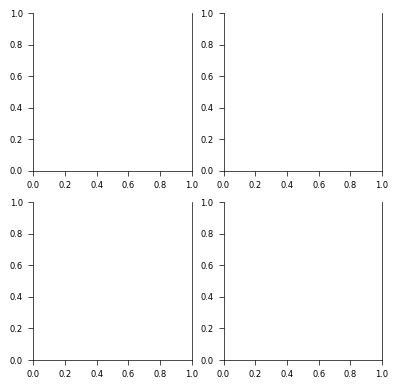

In [21]:
# setup
FIGSIZE = (4.5, 4.5)
_, ax = plt.subplots(2, 2, figsize=FIGSIZE)

# KILOSORT 4 --------------

# plot NS
isolation.plot_unit_isolation_by_drift_corr(ax[0], ks4_ns_v100_corr, ks4_ns_rtx_corr, ks4_ns_rtx_no_corr, legend_cfg);
ax[0].set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1]);
ax[0].set_title('ks4 - NS')
plt.tight_layout(w_pad=2)

# plot NE
isolation.plot_unit_isolation_by_drift_corr(ax[1], ks4_ne_v100_corr, ks4_ne_rtx_corr, ks4_ne_rtx_no_corr, legend_cfg);
ax[1].set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1]);
ax[1].set_title('ks4 - NE')
plt.tight_layout(w_pad=2)

# KILOSORT 3 --------------

# plot NS
isolation.plot_unit_isolation_by_drift_corr(ax[0], ks3_ns_v100_corr, ks3_ns_rtx_corr, ks3_ns_rtx_no_corr, legend_cfg);
ax[0].set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1]);
ax[0].set_title('ks3 - NS')
plt.tight_layout(w_pad=2)

# plot NE
isolation.plot_unit_isolation_by_drift_corr(ax[1], ks3_ne_v100_corr, ks3_ne_rtx_corr, ks3_ne_rtx_no_corr, legend_cfg);
ax[1].set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1]);
ax[1].set_title('ks3 - NE')
plt.tight_layout(w_pad=2)

# save figures
plt.savefig("figures/7_reviews/fig_xx_effect_of_drift_corr.svg", **savefig_cfg)

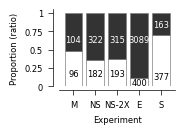

In [ ]:
# setup
FIGSIZE = (1.5, 1)
_, ax = plt.subplots(1, 1, figsize=FIGSIZE)

# plot
isolation.plot_unit_isolation(ax, df_nv, df_ns, df_ns_2X, df_ne, df_nb, legend_cfg)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])

# save figures
# plt.savefig(
#     "figures/1_sorting_quality/yield/assets/fig5A_npx_unit_isolation.svg",
#     **savefig_cfg,
# )

In [7]:
# number of single-units
good_m = sum(df_nv["kslabel"] == "good")
good_ns = sum(df_ns["kslabel"] == "good")
good_ns2x = sum(df_ns_2X["kslabel"] == "good")
good_e = sum(df_ne["kslabel"] == "good")
good_s = sum(df_nb["kslabel"] == "good")

# number of total sorted units
total_m = len(df_nv["kslabel"])
total_ns = len(df_ns["kslabel"])
total_ns2x = len(df_ns_2X["kslabel"])
total_e = len(df_ne["kslabel"])
total_s = len(df_nb["kslabel"])

good_npx = np.array([good_m, good_ns, good_ns2x, good_e, good_s])
total_npx = np.array([total_m, total_ns, total_ns2x, total_e, total_s])

### Hyp. Testing: the proportion of single-units is the same across experiments

#### Spontaneous regimes

In [31]:
# report stats
ddof = 0  # default adjustment of the degree of freedom
dof = len(good_npx[:3]) - 1 - ddof  # the degree of freedom
result = stats.chisquare(f_obs=good_npx[:3] / total_npx[:3] * 100, ddof=0)
print("\nNPX:")
print(
    "expected sorting accuracy:",
    np.round(np.mean(good_npx[:3] / total_npx[:3] * 100)),
    "%",
)
print(
    f"\chi^2 ({dof}, {sum(total_npx[:3])})={np.round(result.statistic,1)}, p={result.pvalue}"
)


NPX:
expected sorting accuracy: 41.0 %
\chi^2 (2, 1212)=2.0, p=0.3666237758281437


#### Spontaneous vs. evoked

In [38]:
# report stats
ddof = 0  # default adjustment of the degree of freedom
dof = len(good_npx[[1, 3]]) - 1 - ddof  # the degree of freedom
result = stats.chisquare(f_obs=good_npx[[1, 3]] / total_npx[[1, 3]] * 100, ddof=0)
print("\nNPX:")
print(
    "expected sorting accuracy:",
    np.round(np.mean(good_npx[[1, 3]] / total_npx[[1, 3]] * 100)),
    "%",
)
print(
    f"\chi^2 ({dof}, {sum(total_npx[[1, 3]])})={np.round(result.statistic,1)}, p={result.pvalue}"
)


NPX:
expected sorting accuracy: 24.0 %
\chi^2 (1, 3993)=12.8, p=0.0003525852052219466


#### Synthetic vs. vivo

In [40]:
# report stats
ddof = 0  # default adjustment of the degree of freedom
dof = len(good_npx[[0, 4]]) - 1 - ddof  # the degree of freedom
result = stats.chisquare(f_obs=good_npx[[0, 4]] / total_npx[[0, 4]] * 100, ddof=0)
print("\nNPX:")
print(
    "expected sorting accuracy:",
    np.round(np.mean(good_npx[[0, 4]] / total_npx[[0, 4]] * 100)),
    "%",
)
print(
    f"\chi^2 ({dof}, {sum(total_npx[[0,4]])})={np.round(result.statistic,1)}, p={result.pvalue}"
)


NPX:
expected sorting accuracy: 59.0 %
\chi^2 (1, 740)=4.0, p=0.04445298002456542


## Isolation dense probe

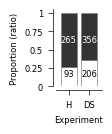

In [9]:
# get metadata
df_hv1 = fr.get_sorted_unit_meta(SORTED_HV1)
df_hv2 = fr.get_sorted_unit_meta(SORTED_HV2)
df_hv3 = fr.get_sorted_unit_meta(SORTED_HV3)
df_hs1 = fr.get_sorted_unit_meta(SORTED_HS1)
df_hs2 = fr.get_sorted_unit_meta(SORTED_HS2)
df_hs3 = fr.get_sorted_unit_meta(SORTED_HS3)

# keep units in cortex
df_hv1 = df_hv1[np.isin(df_hv1["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_hv2 = df_hv2[np.isin(df_hv2["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_hv3 = df_hv3[np.isin(df_hv3["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_hs1 = df_hs1[np.isin(df_hs1["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_hs2 = df_hs2[np.isin(df_hs2["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]
df_hs3 = df_hs3[np.isin(df_hs3["layer"], ["L1", "L2/3", "L4", "L5", "L6"])]

# unit-test: check all in cortex
assert all(
    np.isin(np.sort(df_hv1["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_hv2["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_hv3["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"

assert all(
    np.isin(np.sort(df_hs1["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_hs2["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"
assert all(
    np.isin(np.sort(df_hs3["layer"].unique()), ["L1", "L2/3", "L4", "L5", "L6"])
), "nor all in cortex"

# setup
FIGSIZE = (0.6, 1)
_, ax = plt.subplots(1, 1, figsize=FIGSIZE)

# plot
ax = isolation.plot_unit_isolation_dense_probe(
    ax, df_hv1, df_hv2, df_hv3, df_hs1, df_hs2, df_hs3
)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])

# save figures
plt.savefig(
    "figures/1_sorting_quality/yield/assets/fig5B_dense_unit_isolation.svg",
    **savefig_cfg,
)

### Hyp. Testing: the proportion of single-units is the same across experiments

In [24]:
good_hv1 = sum(df_hv1["kslabel"] == "good")
good_hv2 = sum(df_hv2["kslabel"] == "good")
good_hv3 = sum(df_hv3["kslabel"] == "good")
good_h = good_hv1 + good_hv2 + good_hv3
total_h = len(df_hv1["kslabel"]) + len(df_hv2["kslabel"]) + len(df_hv3["kslabel"])

good_hs1 = sum(df_hs1["kslabel"] == "good")
good_hs2 = sum(df_hs2["kslabel"] == "good")
good_hs3 = sum(df_hs3["kslabel"] == "good")

good_ds = good_hs1 + good_hs2 + good_hs3
total_ds = len(df_hs1["kslabel"]) + len(df_hs2["kslabel"]) + len(df_hs3["kslabel"])

good_dense = np.array([good_h, good_ds])
total_dense = np.array([total_h, total_ds])

array([ 93, 206])

In [26]:
# report stats
ddof = 0  # default adjustment of the degree of freedom
dof = len(good_dense) - 1 - ddof  # the degree of freedom
result = stats.chisquare(f_obs=good_dense / total_dense * 100, ddof=0)
print("\ndense:")
print(
    "expected sorting accuracy:", np.round(np.mean(good_dense / total_dense * 100)), "%"
)
print(
    f"\chi^2 ({dof}, {sum(total_dense)})={np.round(result.statistic,1)}, p={result.pvalue}"
)


dense:
expected sorting accuracy: 31.0 %
\chi^2 (1, 920)=1.8, p=0.17729337530535055


### Hyp. testing: single-unit ratio is the same between probe

* we compared the average ratios of (M,NS) and (H, DS)

In [47]:
good_probes_v = np.array([good_npx[0], good_dense[0]])
total_probes_v = np.array([total_npx[0], total_dense[0]])

# report stats
ddof = 0  # default adjustment of the degree of freedom
dof = len(good_probes_v) - 1 - ddof  # the degree of freedom
result = stats.chisquare(f_obs=good_probes_v / total_probes_v * 100, ddof=0)
print("\ndense:")
print(
    "expected sorting accuracy:",
    np.round(np.mean(good_probes_v / total_probes_v * 100)),
    "%",
)
print(
    f"\chi^2 ({dof}, {sum(total_probes_v)})={np.round(result.statistic,1)}, p={result.pvalue}"
)


dense:
expected sorting accuracy: 37.0 %
\chi^2 (1, 558)=6.6, p=0.010454200240941174


In [56]:
good_probes_s = np.array([good_npx[1], good_dense[1]])
total_probes_s = np.array([total_npx[1], total_dense[1]])

# report stats
ddof = 0  # default adjustment of the degree of freedom
dof = len(good_probes_s) - 1 - ddof  # the degree of freedom
result = stats.chisquare(f_obs=good_probes_s / total_probes_s * 100, ddof=0)
print("\ndense:")
print(
    "expected sorting accuracy:",
    np.round(np.mean(good_probes_s / total_probes_s * 100)),
    "%",
)
print(f"\chi^2 ({dof}, {sum(total_probes_s)})={result.statistic}, p={result.pvalue}")


dense:
expected sorting accuracy: 36.0 %
\chi^2 (1, 1066)=0.004062372471720449, p=0.9491798471326721


420

In [24]:
# evoked testing
import spikeinterface as si
Sref = si.load_extractor("/home/steeve/steeve/epfl/code/spikebias/dataset/01_intermediate/sorting/npx_evoked/SortingKS4_10m") # 384 sites
S10 = si.load_extractor("/home/steeve/steeve/epfl/code/spikebias/temp/npx_evoked_20khz/10m/SortingKS4_10m_RTX5090_DriftCorr") # 202 sites
S7 = si.load_extractor("/home/steeve/steeve/epfl/code/spikebias/temp/npx_evoked_20khz/7m/SortingKS4_5m_RTX5090_DriftCorr") # 303 sites
S5 = si.load_extractor("/home/steeve/steeve/epfl/code/spikebias/temp/npx_evoked_20khz/5m/SortingKS4_5m_RTX5090_DriftCorr") # 303 sites

print('10m - total', len(Sref.unit_ids), '- good' ,sum(Sref.get_property('KSLabel')=='good'))
print('10m - total', len(S10.unit_ids), '- good', sum(S10.get_property('KSLabel')=='good'))
print('7m - total', len(S7.unit_ids), '- <good', sum(S7.get_property('KSLabel')=='good'))
print('5m - total', len(S5.unit_ids), '- good' ,sum(S5.get_property('KSLabel')=='good'))

S10no = si.load_extractor("/home/steeve/steeve/epfl/code/spikebias/temp/npx_evoked_20khz/10m/SortingKS4_10m_RTX5090_NoDriftCorr") # 202 sites
print('10m - total', len(S10no.unit_ids), '- good', sum(S10.get_property('KSLabel')=='good'))

10m - total 3529 - good 408
10m - total 46 - good 17
7m - total 36 - <good 16
5m - total 21 - good 8
10m - total 44 - good 17


In [2]:
# evoked testing
import spikeinterface as si
Sref = si.load_extractor("/home/steeve/steeve/epfl/code/spikebias/dataset/01_intermediate/sorting/npx_evoked/SortingKS4_10m") # 384 sites
S10 = si.load_extractor("/home/steeve/steeve/epfl/code/spikebias/temp/npx_evoked_20khz/10m/SortingKS4_10m_RTX5090_DriftCorr") # 202 sites
S7 = si.load_extractor("/home/steeve/steeve/epfl/code/spikebias/temp/npx_evoked_20khz/7m/SortingKS4_5m_RTX5090_DriftCorr") # 303 sites
S5 = si.load_extractor("/home/steeve/steeve/epfl/code/spikebias/temp/npx_evoked_20khz/5m/SortingKS4_5m_RTX5090_DriftCorr") # 303 sites

print('10m - total', len(Sref.unit_ids), '- good' ,sum(Sref.get_property('KSLabel')=='good'))
print('10m - total', len(S10.unit_ids), '- good', sum(S10.get_property('KSLabel')=='good'))
print('7m - total', len(S7.unit_ids), '- <good', sum(S7.get_property('KSLabel')=='good'))
print('5m - total', len(S5.unit_ids), '- good' ,sum(S5.get_property('KSLabel')=='good'))

S10no = si.load_extractor("/home/steeve/steeve/epfl/code/spikebias/temp/npx_evoked_20khz/10m/SortingKS4_10m_RTX5090_NoDriftCorr") # 202 sites
print('10m - total', len(S10no.unit_ids), '- good', sum(S10.get_property('KSLabel')=='good'))

10m - total 3529 - good 408
10m - total 3540 - good 412
7m - total 36 - <good 16
5m - total 21 - good 8
10m - total 3577 - good 412
